# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-7tap40hh
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-7tap40hh
  Resolved https://github.com/albumentations-team/albumentations to commit c70e664e060bfd7463c20674927aed217f72d437
  Preparing metadata (setup.py) ... done


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


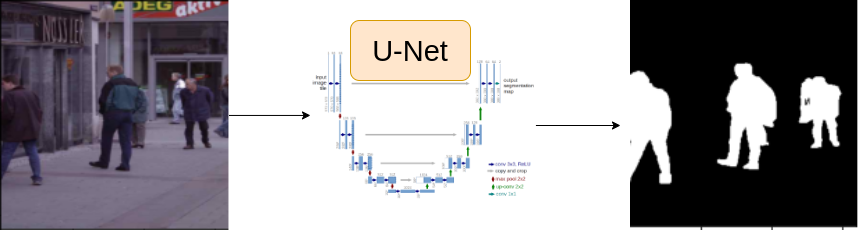

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 4

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
# Read a particular line from te dataset
row = df.iloc[4]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

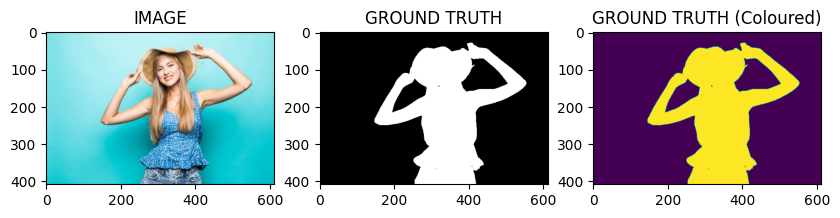

In [8]:
# Plot the images that we have collected
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')  # Converted to grayscale from coloured

ax3.set_title('GROUND TRUTH (Coloured)')
ax3.imshow(mask)

In [9]:
# Split the dataset into test and train dataset with the test size being 0.2

train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A  # Helps us to do the same action for image and it's mask

In [11]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE), # Height and Width of the image
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ], is_check_shapes = False )

def get_test_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE)  # Only resize is needed, no need to flip for test dataset.
  ], is_check_shapes = False )

# Task 4 : Create Custom Dataset

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (h, w, c)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    # (h, w, c) -> (c, h, w)

    image = np.transpose(image,(2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask,(2, 0, 1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0) # To round of the values between 0 and 1

    return image, mask



In [14]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_test_augs())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


Shape of Image:torch.Size([3, 320, 320])
Shape of Mask:torch.Size([1, 320, 320])


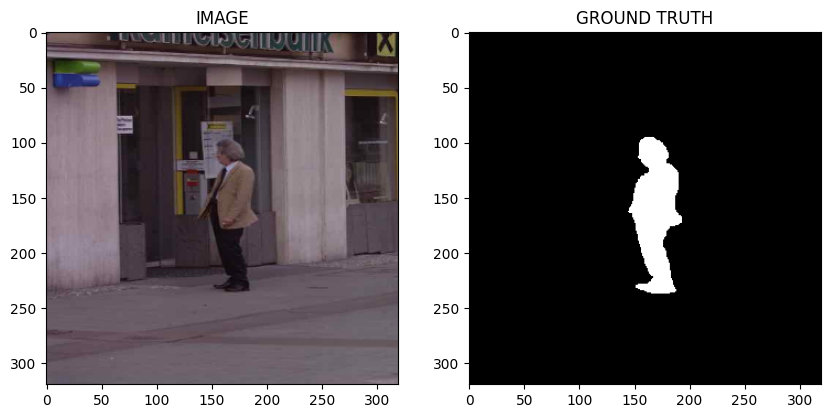

In [16]:
idx = 5

image, mask = trainset[idx]

print(f"Shape of Image:{image.shape}")
print(f"Shape of Mask:{mask.shape}")

helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [19]:
print(f"Total number of batches in trainloader: {len(trainloader)}")
print(f"Total number of batches in validloader: {len(validloader)}")

Total number of batches in trainloader: 58
Total number of batches in validloader: 15


In [20]:
for image, mask in trainloader:
  break

print(f"One batch image shape:{image.shape}")
print(f"One batch mask shape:{mask.shape}")

# Had to add ", is_check_shapes=False" in the A.Compose function

One batch image shape:torch.Size([4, 3, 320, 320])
One batch mask shape:torch.Size([4, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [21]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [22]:
class SegmentationModel(nn.Module):

  def __init__(self):

    super(SegmentationModel, self).__init__()  # Not a problem,just calling the super class here

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode = 'binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)

      return logits, loss1 + loss2

    return logits


In [23]:
model = SegmentationModel()
model.to(DEVICE); # semi-colon to remove the output, which is the architecture of the model that we have just made

# Task 7 : Create Train and Validation Function

In [24]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0

  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)   # Please be careful about the variables image and images, mask and masks
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(data_loader)  # Average loss of the training


In [25]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss/len(data_loader)  # Average loss of the training


# Task 8 : Train Model

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [27]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print('SAVED MODEL')
    best_valid_loss = valid_loss

  print(f'Epoch: {i+1} Train_loss: {train_loss} Valid_loss: {valid_loss}')

100%|██████████| 15/15 [00:00<00:00, 18.27it/s]


SAVED MODEL
Epoch: 1 Train_loss: 0.68589530628303 Valid_loss: 0.43918073177337646


100%|██████████| 15/15 [00:00<00:00, 19.45it/s]


Epoch: 2 Train_loss: 0.48543652969187706 Valid_loss: 0.47973447243372597


100%|██████████| 15/15 [00:00<00:00, 19.47it/s]


SAVED MODEL
Epoch: 3 Train_loss: 0.43463277020331087 Valid_loss: 0.42325816452503207


100%|██████████| 15/15 [00:00<00:00, 15.37it/s]


SAVED MODEL
Epoch: 4 Train_loss: 0.47736698491819973 Valid_loss: 0.38153862953186035


100%|██████████| 15/15 [00:00<00:00, 19.76it/s]


SAVED MODEL
Epoch: 5 Train_loss: 0.4210225875521528 Valid_loss: 0.26107491850852965


100%|██████████| 15/15 [00:00<00:00, 20.01it/s]


Epoch: 6 Train_loss: 0.354668863631528 Valid_loss: 0.29566590785980223


100%|██████████| 15/15 [00:00<00:00, 15.11it/s]


Epoch: 7 Train_loss: 0.3300364798512952 Valid_loss: 0.26914055049419405


100%|██████████| 15/15 [00:00<00:00, 19.90it/s]


Epoch: 8 Train_loss: 0.3062178222783681 Valid_loss: 0.2982706934213638


100%|██████████| 15/15 [00:00<00:00, 19.99it/s]


Epoch: 9 Train_loss: 0.28879039207923 Valid_loss: 0.3378422915935516


100%|██████████| 15/15 [00:00<00:00, 19.93it/s]


Epoch: 10 Train_loss: 0.2754983317492337 Valid_loss: 0.27520994991064074


100%|██████████| 15/15 [00:00<00:00, 19.86it/s]


Epoch: 11 Train_loss: 0.24642577446226416 Valid_loss: 0.26393322745958964


100%|██████████| 15/15 [00:01<00:00, 14.42it/s]


SAVED MODEL
Epoch: 12 Train_loss: 0.22327102271133456 Valid_loss: 0.24392679582039514


100%|██████████| 15/15 [00:00<00:00, 19.99it/s]


SAVED MODEL
Epoch: 13 Train_loss: 0.25012163265511905 Valid_loss: 0.22710294673840206


100%|██████████| 15/15 [00:00<00:00, 19.89it/s]


SAVED MODEL
Epoch: 14 Train_loss: 0.21635471040318752 Valid_loss: 0.22425442983706792


100%|██████████| 15/15 [00:00<00:00, 19.97it/s]


Epoch: 15 Train_loss: 0.23937184235145306 Valid_loss: 0.27345675428708394


100%|██████████| 15/15 [00:00<00:00, 19.69it/s]


Epoch: 16 Train_loss: 0.23142684199686708 Valid_loss: 0.23180164595444996


100%|██████████| 15/15 [00:00<00:00, 15.26it/s]


Epoch: 17 Train_loss: 0.23095273342112016 Valid_loss: 0.29798008501529694


100%|██████████| 15/15 [00:00<00:00, 20.04it/s]


SAVED MODEL
Epoch: 18 Train_loss: 0.1799276576473795 Valid_loss: 0.1860435222585996


100%|██████████| 15/15 [00:00<00:00, 16.59it/s]


Epoch: 19 Train_loss: 0.1683839556985888 Valid_loss: 0.24751290529966355


100%|██████████| 15/15 [00:00<00:00, 18.72it/s]


Epoch: 20 Train_loss: 0.18377558976925654 Valid_loss: 0.20456333905458451


100%|██████████| 15/15 [00:00<00:00, 19.52it/s]


SAVED MODEL
Epoch: 21 Train_loss: 0.14541966031337605 Valid_loss: 0.17475012590487798


100%|██████████| 15/15 [00:00<00:00, 15.68it/s]


Epoch: 22 Train_loss: 0.15373842084202274 Valid_loss: 0.34349180658658346


100%|██████████| 15/15 [00:00<00:00, 19.87it/s]


Epoch: 23 Train_loss: 0.22609507356738223 Valid_loss: 0.30439383337895076


100%|██████████| 15/15 [00:01<00:00, 14.74it/s]


Epoch: 24 Train_loss: 0.16782668868786302 Valid_loss: 0.24704563915729522


100%|██████████| 15/15 [00:00<00:00, 20.13it/s]

Epoch: 25 Train_loss: 0.1410656232258369 Valid_loss: 0.20607945521672566


# Task 9 : Inference

In [28]:
idx = 20

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C, H, W) -> (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

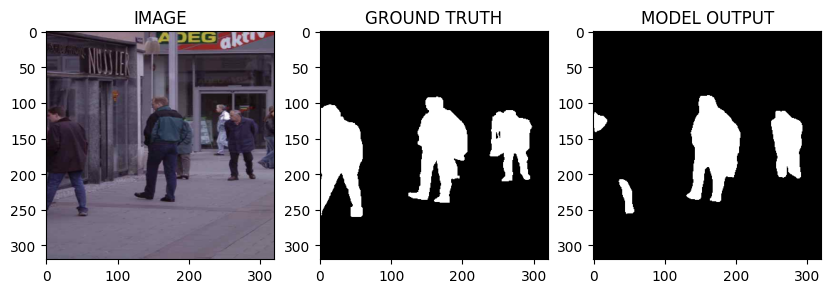

In [29]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))